In [396]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MultiLabelBinarizer
import nltk
from nltk import FreqDist
from nltk.util import ngrams
from nltk.corpus import stopwords
from collections import defaultdict
from nltk import bigrams
from sklearn.feature_selection import chi2


# Predicting the Genres of Songs by their Lyrics

Navigating music's vast landscape, we often rely on genres to classify songs. In this project, we apply machine learning techniques to predict whether a song is pop, rock or rap based on its lyrics. Using natural language processing, we'll identify the key phrases that set these genres apart.

| <center>Pop</center> | <center>Rock</center> | <center>Rap</center> |
|----------|----------|----------|
| <img src="pictures/arianagrande.png" width="300"> | <img src="pictures/metallica.png" width="300"> | <img src="pictures/snoopdog.jpg" width="300"> |
| Ooh-ooh-ooh-ooh | Darkness, imprisoning me | Right back up in your mothafuckin' ass
Love me, love me, love me |  All that I see, absolute horror | 9-5 plus four pennies, add that shit up
Ooh-ooh-ooh-ooh | I cannot live, I cannot die | D.R.E. right back up on top of thangs
Harder (you gotta love me harder) | Trapped in myself, body my holding cell | Smoke some wit' your Dogg



## Table Of Contents

### Load the Datasets
We have two datasets: one with lyrics (lyrics_dataset.csv) and another with artist information (artists_dataset.csv). We'll load both into pandas DataFrames.
The lyrics dataset is too large to be posted on github directly so here is the link to both datasets: https://www.kaggle.com/datasets/neisse/scrapped-lyrics-from-6-genres/data

In [397]:
artists_df = pd.read_csv('data/artists-data.csv')
lyrics_df = pd.read_csv('data/lyrics-data.csv',delimiter=',', quotechar='"')

### Data Preprocessing
Before we can analyze the data, we need to preprocess it. This includes standardizing the column with the link to the artist's account and merging the two datasets on this column.
We are going to work with English songs only for this project.


In [398]:
# remove leading/trailing spaces if any
artists_df['Link'] = artists_df['Link'].str.strip()
lyrics_df['ALink'] = lyrics_df['ALink'].str.strip()

# merge the datasets on the link to the artist's account
merged_df = pd.merge(lyrics_df, artists_df, left_on='ALink', right_on='Link', how='left')

 Dropping the rows with missing lyrics or genres

In [399]:
# handle missing values (drop rows with missing lyrics or genres)
merged_df.dropna(subset=['Lyric', 'Genres'], inplace=True)

# Replace \r and \n in 'Lyric' only if the entry is a string
merged_df['Lyric'] = merged_df['Lyric'].apply(lambda x: x.replace('\r', '').replace('\n', ' ') if isinstance(x, str) else x)



 Filtering Out Non-English Songs

In [400]:
# identify artists with Non-English songs
nonenglish_artists = set(merged_df[merged_df['language'] != 'en']['Artist'].unique())

# remove all rows related to artists who have Non-English songs
merged_df = merged_df[~merged_df['Artist'].isin(nonenglish_artists)]


Taking a look at the genres available in the data. **And that's when I decided I will work with 3 genres only!**

In [401]:

from collections import Counter

# splitting the genres and creating a flat list
all_genres = [genre for sublist in merged_df['Genres'].dropna() for genre in sublist.split(';')]

# counting the occurrences of each genre
genre_counts = Counter(all_genres)

# display the total count of unique genres
total_unique_genres = len(genre_counts)
print(f"Total unique genres: {total_unique_genres}")

# displaying the first 6 most common genres
print("\nFirst 6 most common genres:")
for genre, count in genre_counts.most_common(6):
    print(f"{genre}: {count}")

# displaying the last 2 genres
# if there are fewer than 8 genres, this will display however many there are, not repeating the first 6
print("\nLast 2 genres:")
for genre, count in list(genre_counts.most_common())[-2:]:
    print(f"{genre}: {count}")


Total unique genres: 113

First 6 most common genres:
 Rock: 11091
Rock: 5660
Country: 5599
 Hip Hop: 5550
Rap: 4985
 Pop: 4643

Last 2 genres:
Electro Swing: 6
K-Pop/K-Rock: 2


Standardizing the genres - removing whitespace, splitting multiple ones described as one (hybrid genres, they are going to be too complicated to work with).

In [402]:
# function to standardize genre names
# ensure 'Genres' is a string and split genres into a list
merged_df['Genres'] = merged_df['Genres'].astype(str).apply(lambda x: x.split(';'))

# Standardize genres by stripping whitespace and converting to lowercase
def standardize_genres(genre_list):
    standardized = [genre.strip().lower() for genre in genre_list]
    return standardized

merged_df['Genres'] = merged_df['Genres'].apply(standardize_genres)

# keep hybrid genres as is
hybrid_genres = {genre for genre in all_genres if '/' in genre}
print("Hybrid genres:", hybrid_genres)

# Split hybrid genres into individual genres
def standardize_genres(genre_list):
    standardized = []
    for genre in genre_list:
        if '/' in genre:  # Detect hybrid genres
            standardized.extend(genre.split('/'))  # Split and extend the list
        else:
            standardized.append(genre.strip().lower())
    return standardized

merged_df['Genres'] = merged_df['Genres'].apply(standardize_genres)


Hybrid genres: {' Pop/Punk', 'Gospel/Religioso', ' Pop/Rock', ' K-Pop/K-Rock', ' Gospel/Religioso', 'Pop/Rock', 'Pop/Punk', ' J-Pop/J-Rock', 'K-Pop/K-Rock'}


Now that the genres are stardartized, let's get rid of the unneeded ones. However, there is still an issue with multiple genre songs.
Primarily because the genre column is linked to the artist more than to the specific song. 
**So we are only going to work with artists/songs that have only ONE of the genres we are looking for.** Another interesting option would be treating a pop/rock song as both, but the result sounds too scary for now. Going back to the project after a while, I could try doing it this way.

In [403]:
# define the genres of interest
genres_of_interest = ['pop', 'rock', 'rap']

# gilter for songs that have at least one of the genres of interest and are in English
filtered_songs_df = merged_df[
    merged_df['language'] == 'en'  # Songs must be in English
].copy()

# include songs that have any of the genres of interest
filtered_songs_df = filtered_songs_df[
    filtered_songs_df['Genres'].apply(lambda genres: any(genre in genres_of_interest for genre in genres))
]

# filter the DataFrame to include songs with exactly one of the genres of interest
exclusive_genre_songs_df = filtered_songs_df[
    filtered_songs_df['Genres'].apply(lambda genres: sum(genre in genres_of_interest for genre in genres) == 1)
].copy()

# extract the relevant genre from the list
exclusive_genre_songs_df['Single_Genre'] = exclusive_genre_songs_df['Genres'].apply(
    lambda genres: next(genre for genre in genres if genre in genres_of_interest)
)

# Check how many songs contain any of the genres of interest
print("Songs with any of the genres of interest:", len(filtered_songs_df))

# Check how many songs are exclusively categorized under one of the genres of interest
print("Songs with exactly one of the genres of interest:", len(exclusive_genre_songs_df))






Songs with any of the genres of interest: 33204
Songs with exactly one of the genres of interest: 25952


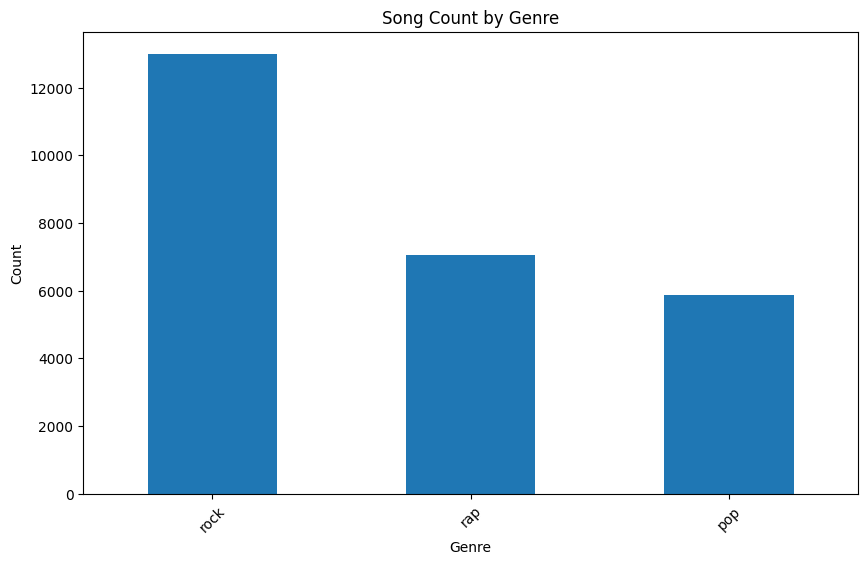

In [404]:
# filter for songs that are exclusively categorized as one of the genres of interest
# explode the 'Genres' column into separate rows
exploded_genres = exclusive_genre_songs_df['Single_Genre'].explode()

# filter for only genres of interest
genre_counts = exploded_genres[exploded_genres.isin(genres_of_interest)].value_counts()


# create a bar chart of genres
plt.figure(figsize=(10, 6))
genre_counts.plot(kind='bar')
plt.title('Song Count by Genre')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45) 
plt.show()




The amount of rock songs it twice the amount of the others, let's remove half of them randomly so that they are all about equal.

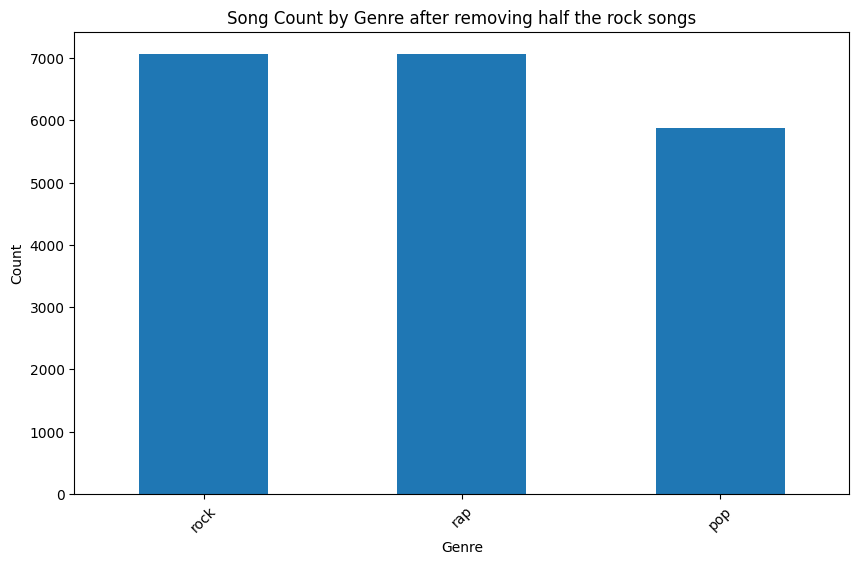

In [405]:
pop_songs = exclusive_genre_songs_df[exclusive_genre_songs_df['Single_Genre'] == 'pop']
rock_songs = exclusive_genre_songs_df[exclusive_genre_songs_df['Single_Genre'] == 'rock']
rap_songs = exclusive_genre_songs_df[exclusive_genre_songs_df['Single_Genre'] == 'rap']

# Find the number of songs to match
target_song_count = max(len(pop_songs), len(rap_songs))

# Downsample the rock songs
rock_songs_downsampled = rock_songs.sample(n=target_song_count, random_state=42)

balanced_songs_df = pd.concat([pop_songs, rock_songs_downsampled, rap_songs], ignore_index=True)

balanced_songs_df = balanced_songs_df.sample(frac=1, random_state=42).reset_index(drop=True)


exploded_genres = balanced_songs_df['Single_Genre'].explode()

# filter for only genres of interest
genre_counts = exploded_genres[exploded_genres.isin(genres_of_interest)].value_counts()


# create a bar chart of genres
plt.figure(figsize=(10, 6))
genre_counts.plot(kind='bar')
plt.title('Song Count by Genre after removing half the rock songs')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45) 
plt.show()



Here is how our data looks in the table so far:

In [406]:
# Create a sample DataFrame with truncated lyrics
sample_df = balanced_songs_df.sample(n=5).copy()
sample_df['Lyric'] = sample_df['Lyric'].str[:30] + '...'

# Rename the columns to match the desired output
sample_df.rename(columns={
    'SName': 'song',
    'Artist': 'artist',
    'Single_Genre': 'genre',
    'Lyric': 'lyric'
}, inplace=True)

# Select only the columns we want to display
sample_df = sample_df[['song', 'artist', 'genre', 'lyric']]
sample_df


,song,artist,genre,lyric
3855,Cupid's Got a Gun (Feat. Nicki Minaj),Shanell,pop,[Shanell] You watched me fall...
11539,Don't Make Me Hurt Ya Feelings,Ice Cube,rap,"[Ice Cube] From hood to hood, ..."
12188,Somewhere Over The Rainbow (feat. Gwyneth Palt...,Matthew Morrison,pop,(Matthew Morrison) Somewhere o...
15504,On Repeat,LCD Soundsystem,rock,"Beats on repeat, beating on me..."
16720,Cold Contagious,Bush,rock,Wherever you are You will carr...


Let's take a look at the most common unigrams and bigrams in the currently available lyrics!

In [407]:

from sklearn.feature_extraction import text 

# Default English stopwords
default_stopwords = text.ENGLISH_STOP_WORDS

# Your additional custom stopwords
additional_stopwords = {'na', 'eh', 'don', 'huh', 'll', 'ooh', 'oh', 'uh', 'let', 'got', 'reproduced', 'directed', 'starring'}

# Combine the default and custom stopwords
all_stopwords = default_stopwords.union(additional_stopwords)

# Convert the combined stopwords from a frozenset to a list
all_stopwords_list = list(all_stopwords)

# Create the TfidfVectorizer with the combined list of stopwords
tfidf = TfidfVectorizer(sublinear_tf=True, ngram_range=(1, 2), stop_words=all_stopwords_list, min_df=0.0)


lyrics_vector = tfidf.fit_transform(balanced_songs_df['Lyric'])
labels = balanced_songs_df['Single_Genre'].values

N = 5  # number of examples to display
genre_labels = balanced_songs_df['Single_Genre'].unique() 

for genre in genre_labels:
    category_id = np.where(genre_labels == genre)[0][0]
    features_chi2 = chi2(lyrics_vector, labels == genre)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names_out())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("\n==> %s:" %(genre))
    print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
    print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))
    
tfidf = TfidfVectorizer(ngram_range=(1, 2), stop_words='english', min_df=0.1, max_df=0.4)
lyrics_vector = tfidf.fit_transform(balanced_songs_df['Lyric'])
labels = balanced_songs_df['Single_Genre'].values


==> rock:
  * Most Correlated Unigrams are: fuck, bitch, niggas, shit, nigga
  * Most Correlated Bigrams are: ain gotta, ice cube, rock roll, yeah yeah, tell em

==> rap:
  * Most Correlated Unigrams are: fuck, bitch, shit, niggas, nigga
  * Most Correlated Bigrams are: ain shit, nigga like, tell em, soulja boy, ice cube

==> pop:
  * Most Correlated Unigrams are: bitch, fuck, shit, niggas, nigga
  * Most Correlated Bigrams are: way love, love ve, luciano volpe, por luciano, love love
